In [1]:
import pandas as pd
import pyranges as pr
import upsetplot
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
def plot_end_upset(h5, mode, subset=None, sources=None, gids=None, opref='figures/cerberus'):
    _, tss, tes, _, _, _ = read_h5(h5, as_pyranges=False)
    if mode == 'tss':
        df = tss
    elif mode == 'tes':
        df = tes
    
    # filter ends for gene subset
    if subset:
        df = filter_cerberus_genes(df, subset=subset)
    
    # only plot for detected genes?
    # TODO
    
    # get melted version of regions
    end_upset = upsetplot.from_memberships(df.source.str.split(','), data=df)
    
    # filter for given sources
    temp = pd.DataFrame()
    if sources:
        end_upset.reset_index(inplace=True)
        for source in sources:
            df = end_upset.loc[end_upset[source] == True].copy(deep=True)
            temp = pd.concat([temp, df])
        df = temp
        df.set_index(sources, inplace=True)
    else:
        df = end_upset.copy(deep=True)
    
    # make the plot
    c_dict, _ = get_end_colors()
    c = c_dict[mode]
    fig = plt.figure(figsize=(11,6))
    sns.set_context('paper', font_scale=1.5)
    upsetplot.plot(df, subset_size='auto',
                    show_counts='%d', sort_by='cardinality', 
                    facecolor=c, fig=fig, shading_color='white', element_size=None)

    fname = '{}_{}_source_upset.png'.format(opref, mode)
    plt.savefig(fname, dpi=300, bbox_inches='tight')


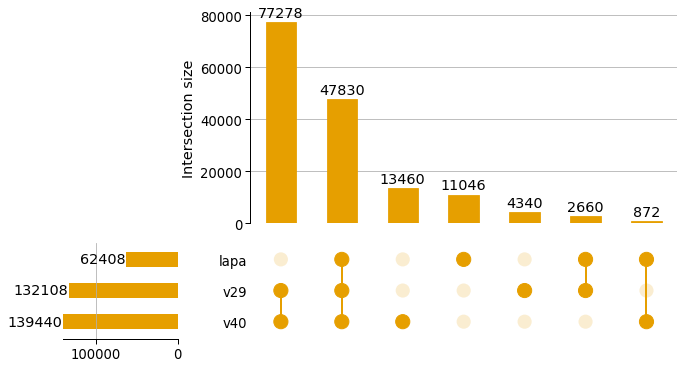

In [3]:
h5 = 'human_cerberus.h5'
plot_end_upset(h5, 'tes', 'polya', opref='figures/cerberus')

In [4]:
ic, tss, df, _, _, m_df = read_h5(h5, as_pyranges=False)

g_df, _, _ = get_gtf_info(how='gene', subset='polya', add_stable_gid=True)
gids = g_df.gid_stable.tolist()
df = df.loc[df.gene_id.isin(gids)]

df['source'] = df.source.str.split(',')
df = df.explode('source')
counts = df[['Name', 'source']].groupby('source').count()
counts.rename({'Name': 'count'}, axis=1, inplace=True)



In [5]:
n_talon = counts.loc['lapa', 'count']
n_v29 = counts.loc['v29', 'count']
n_v40 = counts.loc['v40', 'count']

In [6]:
print('Detected {:.2f}% of v40 TESs'.format((n_talon/n_v40)*100))
print('Detected {:.2f}% of v29 TESs'.format((n_talon/n_v29)*100))

Detected 44.76% of v40 TESs
Detected 47.24% of v29 TESs


## How many ends does each gene have in our entire annotation?

In [3]:
def plot_n_ends_per_gene(annot, mode,
                         sources=None,
                         subset=None,
                         max_ends=10):
    """
    Parameters:
        annot (str): Path to cerberus reference
        mode (str): {'tss', 'tes'}
        subset (str): Which genes to include {None, 'protein_coding', 'polya', 'tf'}
        max_ends (int): Max # of ends
        
    """
    ic, tss, tes, tss_map, tes_map, m_df = read_h5(annot, as_pyranges=False)
    if mode == 'tss':
        df = tss
    elif mode == 'tes':
        df = tes
    
    # filter based on sources
    if sources: 
        df = filter_cerberus_sources(df, sources)
       
    
    df = df[['gene_id', 'Name']]
    df = df.groupby('gene_id').count().reset_index()
    df.rename({'Name': 'n_{}'.format(mode)}, axis=1, inplace=True)
    
    if subset:
        df = filter_cerberus_genes(df, subset=subset)
          
    # create counts df
    df = df.groupby('n_{}'.format(mode)).count().reset_index()
    df.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    n = df.loc[df['n_{}'.format(mode)] >= max_ends, 'n_genes'].sum()
    df = df.loc[df['n_{}'.format(mode)] < max_ends]
    temp = pd.DataFrame()
    temp['n_{}'.format(mode)] = ['{}+'.format(max_ends)]
    temp['n_genes'] = [n]
    df = pd.concat([df, temp])
                    
    # plot
    plt.figure(figsize=(4.5, 3), dpi=300)
    c_dict, order = get_end_colors()

    ax = sns.barplot(data=df, 
                x='n_{}'.format(mode), y='n_genes',
                color=c_dict[mode], saturation=1)

    plt.xlabel('# {}s'.format(mode.upper()))
    plt.ylabel('# genes')
    sns.despine()

In [19]:
h5 = 'cerberus_ref.h5'
ic, tss, tes, tss_map, tes_map, m = read_h5(h5, as_pyranges=False)

In [20]:
df = pd.read_hdf(h5, 'tss_map')
df.head()

,Chromosome,Start,End,Strand,source,Name
0,chr1,169661956,169662057,+,v40,ENSG00000000460_5
1,chr1,169794679,169794780,+,v40,ENSG00000000460_3
2,chr1,169794989,169795129,+,v40,ENSG00000000460_1
3,chr1,169795358,169795459,+,v40,ENSG00000000460_2
4,chr1,169795870,169795971,+,v40,ENSG00000000460_4


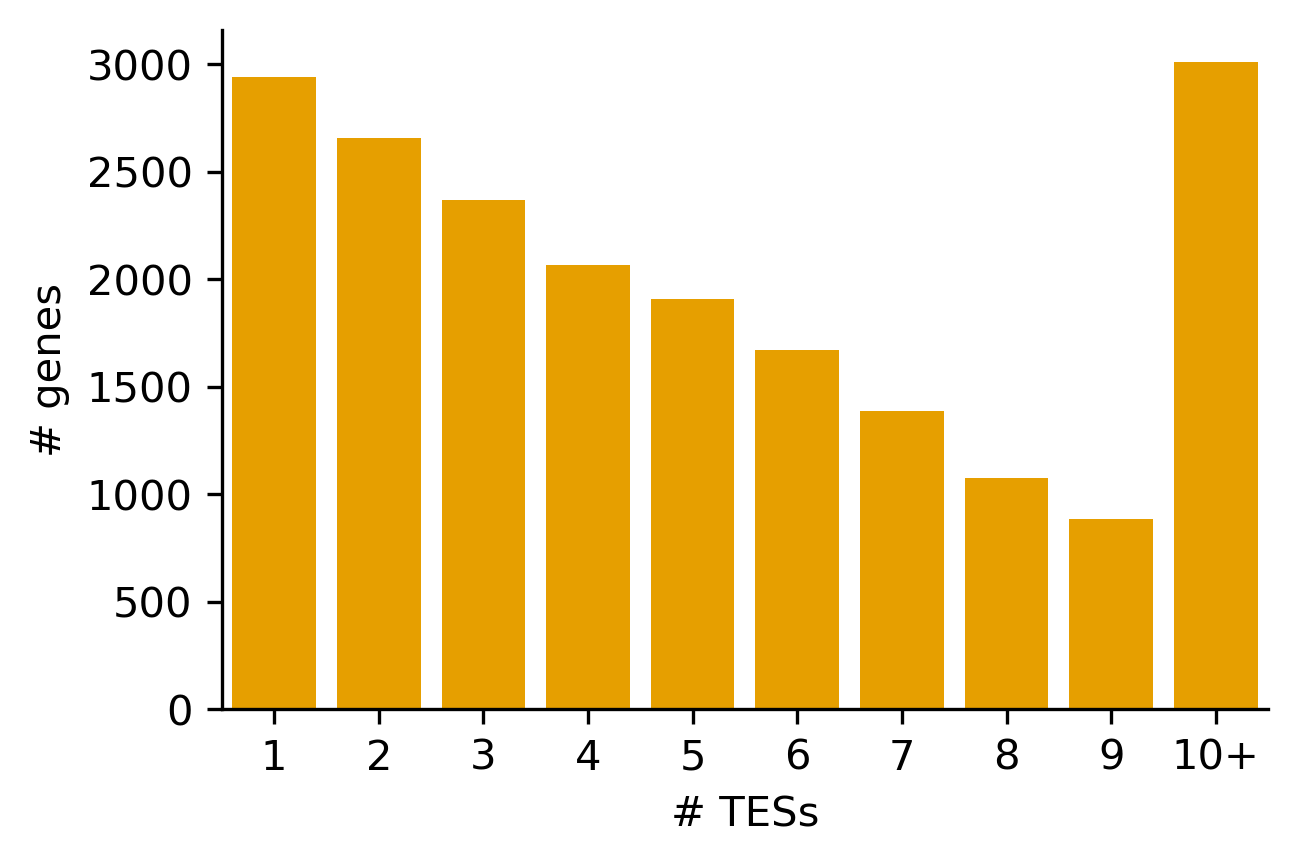

In [4]:
# all ends observed in our data + annotated in GENCODE v29 or 40
h5 = 'human_cerberus.h5'
plot_n_ends_per_gene(h5,
                     mode='tes',
                     subset='protein_coding',
                     max_ends=10)

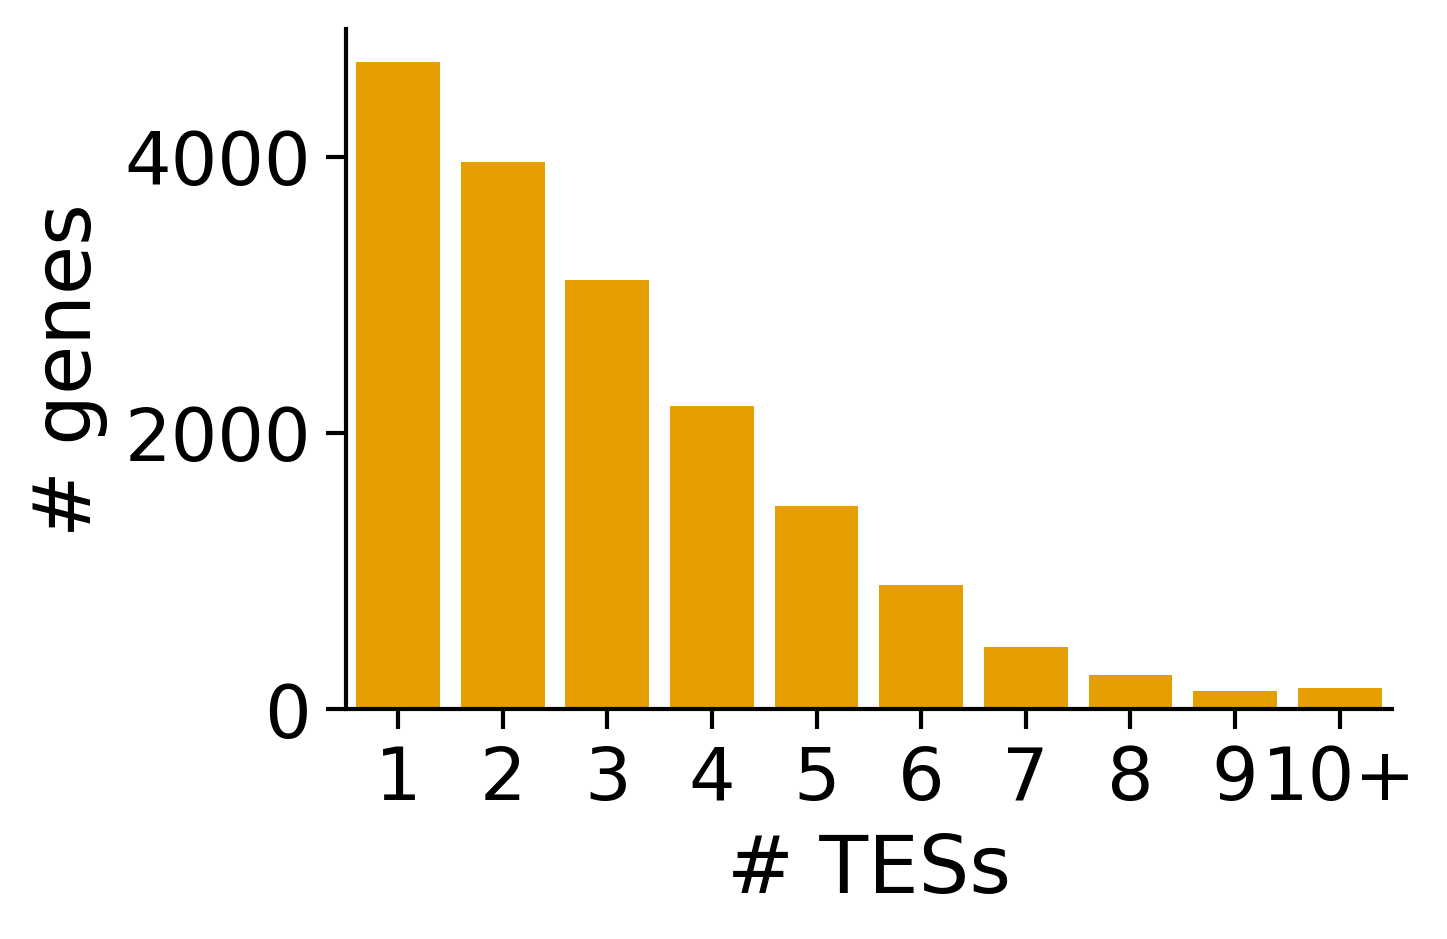

In [27]:
# all ends observed in our data
h5 = 'human_cerberus.h5'
plot_n_ends_per_gene(h5,
                     mode='tes',
                     subset='protein_coding',
                     sources=['lapa'],
                     max_ends=10)

## How many intron chains from the same gene have a different TES? 

In [8]:
def plot_ends_per_ic(h5, mode, subset=None, opref='figures/human'):
    _, _, _, _, _, df = read_h5(h5, as_pyranges=False)
    end_id = '{}_id'.format(mode)
    
    sns.set_context('paper', font_scale=1.8)
    
    
    if subset:
        df = filter_cerberus_genes(df, subset)
    
    # df counting
    # df[['gene_id', 'ic_id', end_id]].head()
    df = df[['gene_id', 'ic_id', end_id]]
    df = df.groupby(['gene_id', 'ic_id']).count().reset_index()
    df.rename({end_id: 'counts'}, axis=1, inplace=True)
    df.sort_values(by='counts', ascending=False)

    # plotting
    c_dict, order = get_end_colors()
    c = c_dict[mode]
    ax = sns.displot(df, x='counts', kind='hist', binwidth=1, linewidth=0, color=c)
    
    xlabel = '# intron chains'
    ylabel = '# {}s'.format(mode.upper())

    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    fname = '{}_{}s_per_ic.png'.format(opref, mode)
    plt.savefig(fname, dpi=300, bbox_inches='tight') 

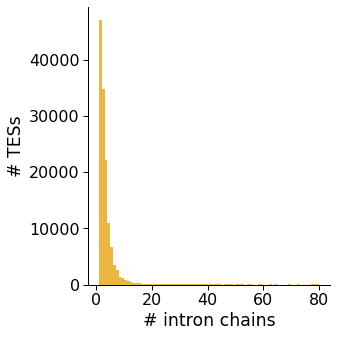

In [16]:
h5 = 'human_cerberus.h5'
plot_ends_per_ic(h5, 'tes', subset='protein_coding')

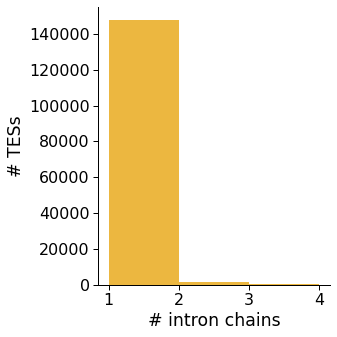

In [17]:
h5 = 'v29_cerberus.h5'
plot_ends_per_ic(h5, 'tes', subset='protein_coding', opref='figures/v29')

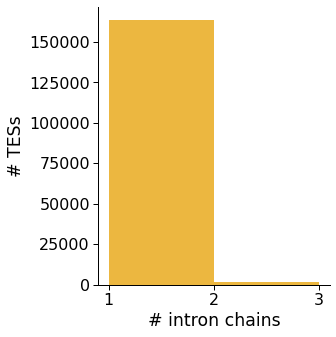

In [18]:
h5 = 'v40_cerberus.h5'
plot_ends_per_ic(h5, 'tes', subset='protein_coding', opref='figures/v40')

## How many ends to we detect per gene compared to GENCODE?

In [94]:
h5 = 'human_cerberus.h5'
mode = 'tes'
source1 = 'v40'
source2 = 'lapa'
xlim=None
ylim=None
label_genes=None
opref= 'figures/human'

_, tss, tes, _, _, _ = read_h5(h5, as_pyranges=False)
if mode == 'tss':
    df = tss
elif mode == 'tes':
    df = tes

In [95]:
s1_ends = df.loc[df.source.str.contains(source1)].copy(deep=True)
s2_ends = df.loc[df.source.str.contains(source2)].copy(deep=True)

In [96]:
def get_ends_per_gene(df):
    df = df[['gene_id', 'Name']]
    df = df.groupby('gene_id').count().reset_index()
    df.rename({'Name': 'counts'}, axis=1, inplace=True)
    return df

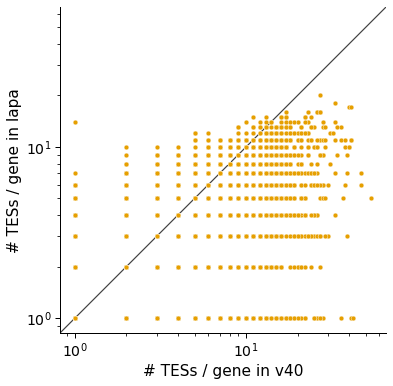

In [97]:
s1_ends = get_ends_per_gene(s1_ends)
s2_ends = get_ends_per_gene(s2_ends)

# merge but only keep entries that we have in both sources
df = s1_ends.merge(s2_ends, how='inner', on='gene_id', 
                   suffixes=('_s1', '_s2'))

c_dict, order = get_end_colors()
c = c_dict[mode]

# plot the figure
sns.set_context('paper', font_scale=1.6)
plt.figure(figsize=(6,6))
ax = sns.scatterplot(data=df, x='counts_s1', y='counts_s2', color=c)

fig = plt.gcf()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = '# {}s / gene in {}'.format(mode.upper(), source1)
ylabel = '# {}s / gene in {}'.format(mode.upper(), source2)
_ = ax.set(xlabel=xlabel, ylabel=ylabel, xscale='log', yscale='log')

fig = plt.gcf()

# set x and y lims if provided
if xlim:
    xlim = (0, xlim)
    ax.set(xlim=xlim)
if ylim:
    ylim = (0, ylim)
    ax.set(ylim=ylim)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# annotate genes that are kinda interesting
if label_genes:
    xlim = ax.get_xlim()[1]
    ylim = ax.get_ylim()[1]
    for g in label_genes:
        if g in df.gname.tolist():
            x = df.loc[df.gname == g, 'counts_s1'].values[0]
            y = df.loc[df.gname == g, 'counts_s2'].values[0]
            if x > 0.2 and y > 0.2:
                # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html#matplotlib.axes.Axes.annotate
                plt.annotate(g, (x,y), fontsize='small', fontstyle='italic', xytext=(4,-5), textcoords='offset pixels')

fname = '{}_{}_v_{}_{}s_per_gene.png'.format(opref, source1, source2, mode)
plt.savefig(fname, dpi=300, bbox_inches='tight')



In [98]:
df.head()

,gene_id,counts_s1,counts_s2
0,ENSG00000000003,4,6
1,ENSG00000000005,2,2
2,ENSG00000000419,6,4
3,ENSG00000000457,4,4
4,ENSG00000000460,5,4


## Sample specificty of 3' ends

In [1]:
import pandas as pd
import pyranges as pr
import upsetplot
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
def read_cerberus_ab(df, 
                     mode):
    """
    Read cerberus abundance file and aggregate over whichever
    feature requested.
    
    Parameters:
        df (str): Path to cerberus abundance file
        mode (str): {'tss', 'ic', 'tes'}
    """
    df = pd.read_csv(df, sep='\t')
    
    # add stable gid
    df['gid_stable'] = df.annot_transcript_id.str.split('[', expand=True)[0]
    
    # extract triplet
    df['triplet'] = df.annot_transcript_id.str.split('[', expand=True)[1]
    df['triplet'] = df.triplet.str.split(']', expand=True)[0]
    df[['tss', 'ic', 'tes']] = df.triplet.str.split(',', expand=True)
    df['triplet'] = df.triplet.str.split(',')
    
    # create id for feature we care about
    df[mode] = df.gid_stable+'_'+df[mode].astype(str)
    
    # drop columns that are irrelevant for end / ic analysis
    drop_cols = ['transcript_ID', 'annot_transcript_id', 'annot_transcript_name',
                 'n_exons', 'length', 'transcript_novelty', 'ISM_subtype']
    drop_cols += list({'tss', 'ic', 'tes'}-set([mode]))
    df.drop(drop_cols, axis=1, inplace=True)
    
    # groupby unique features to ends or ic; sum across transcripts
    gb_cols = ['gene_ID', 'annot_gene_id', 'annot_gene_name', 'gene_novelty', mode]
    # print(df.loc[df[mode] == 'ENSG00000227232_1'].head())
    df = df.groupby(gb_cols).sum().reset_index()
    
    return df    

In [3]:
ab = 'human_cerberus_abundance.tsv'
df = read_cerberus_ab(ab, 'tes')

Calculating tes TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tess detected: 62620
# tess >= 1 tpm: 62620
Applying gene type and novelty subset
Number of tess reported: 62620
Found 50 total samples


UnboundLocalError: local variable 'ylabel' referenced before assignment

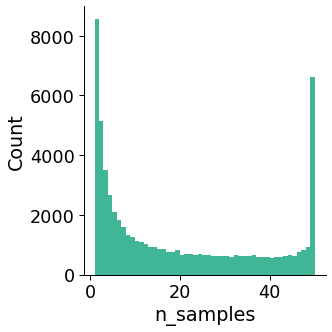

In [4]:
# can I get tpm table??? o.o
df = plot_biosamp_det(df, how='tes', sample='all', groupby='sample', gene_subset='polya', opref='figures/human', nov=None)

In [ ]:
df.head()

In [5]:
df.head()

,gene_ID,annot_gene_id,annot_gene_name,gene_novelty,tes,hl60_m2_12hr_1_1,pgp1_excite_neuron_1_2,h9_neural_crest_1_1,gm12878_1_4,wtc11_1_1,...,left_lung_2_1,hmec_1_1,mcf10a_1_1,calu3_1_2,adrenal_gland_3_1,heart_right_ventricle_1_1,right_lobe_of_liver_1_1,huvec_1_2,hl60_m1_12hr_1_1,pgp1_excite_neuron_1_1
0,2,ENSG00000227232.5,WASH7P,Known,ENSG00000227232_1,14,1,0,0,4,...,0,6,2,12,0,1,0,11,19,0
1,4,ENSG00000243485.5,MIR1302-2HG,Known,ENSG00000243485_1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,6,ENSG00000237613.2,FAM138A,Known,ENSG00000237613_1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,ENSG00000237613.2,FAM138A,Known,ENSG00000237613_2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,ENSG00000238009.6,AL627309.1,Known,ENSG00000238009_5,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
